# Positron Angle Regression Validation

Validate regression predictions from existing parquet prediction files. This notebook does not run inference; it reads `ml_output_*.parquet` truth and `positron_angle_regression` prediction parquet files, aligns by `(event_id, time_group_id)`, and evaluates angular performance (`theta`, `phi`, and 3D angular residuals).


In [1]:
from pathlib import Path
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from pioneerml.common.zenml import utils as zenml_utils


In [2]:
PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"Project root: {PROJECT_ROOT}")

data_dir = PROJECT_ROOT / 'data'
pred_dirs = [data_dir / 'positron_angle_regression', data_dir / 'positron_angle']
pred_dir = next((d for d in pred_dirs if d.exists()), pred_dirs[0])
if not pred_dir.exists():
    raise RuntimeError(
        f"Prediction directory not found: {pred_dirs[0]} (fallback {pred_dirs[1]})"
    )

main_paths = sorted(data_dir.glob('ml_output_*.parquet'))
# Example: uncomment to validate a smaller subset
main_paths = main_paths[:1]
if not main_paths:
    raise RuntimeError(f'No main parquet files found in {data_dir}')

aligned = []
missing = []
for main_path in main_paths:
    p1 = pred_dir / f'{main_path.stem}_preds.parquet'
    p2 = pred_dir / f'{main_path.stem}_preds_latest.parquet'
    pred_path = p1 if p1.exists() else (p2 if p2.exists() else None)
    if pred_path is None:
        missing.append(main_path.name)
        continue
    aligned.append((main_path, pred_path))

if missing:
    raise RuntimeError('Missing predictions for: ' + ', '.join(missing))

print(f'Aligned files: {len(aligned)}')
for m, p in aligned:
    print(f' - {m.name} -> {p.name}')


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace
Aligned files: 1
 - ml_output_000.parquet -> ml_output_000_preds.parquet


In [3]:
TARGET_COLS = ['positron_px', 'positron_py', 'positron_pz']
PRED_BASE_COLS = ['pred_positron_px', 'pred_positron_py', 'pred_positron_pz']

def flatten_truth(main_path: Path) -> pl.DataFrame:
    cols = ['event_id', 'hits_time_group', *TARGET_COLS]
    df = pl.read_parquet(main_path, columns=cols)
    df = df.with_columns(pl.col('hits_time_group').list.unique().list.sort().alias('time_group_ids'))
    out = df.select(['event_id', 'time_group_ids', *TARGET_COLS]).explode(['time_group_ids', *TARGET_COLS])
    out = out.rename({'time_group_ids': 'time_group_id'})
    out = out.with_columns(
        pl.col('event_id').cast(pl.Int64),
        pl.col('time_group_id').cast(pl.Int64).fill_null(-1),
    )
    return out

def flatten_preds(pred_path: Path) -> pl.DataFrame:
    q16_cols = [f'{c}_q16' for c in PRED_BASE_COLS]
    q50_cols = [f'{c}_q50' for c in PRED_BASE_COLS]
    q84_cols = [f'{c}_q84' for c in PRED_BASE_COLS]
    cols = ['event_id', 'time_group_ids', *PRED_BASE_COLS, *q16_cols, *q50_cols, *q84_cols]
    df = pl.read_parquet(pred_path, columns=cols)
    out = df.explode(['time_group_ids', *PRED_BASE_COLS, *q16_cols, *q50_cols, *q84_cols])
    out = out.rename({'time_group_ids': 'time_group_id'})
    out = out.with_columns(
        pl.col('event_id').cast(pl.Int64),
        pl.col('time_group_id').cast(pl.Int64).fill_null(-1),
    )
    out = out.filter(pl.all_horizontal(*[pl.col(c).is_not_null() for c in q50_cols]))
    return out

joined_frames = []
for main_path, pred_path in aligned:
    truth = flatten_truth(main_path)
    pred = flatten_preds(pred_path)
    joined = truth.join(pred, on=['event_id', 'time_group_id'], how='inner')
    if joined.height != pred.height:
        raise RuntimeError(
            f'Alignment mismatch for {main_path.name} / {pred_path.name}: '
            f'truth={truth.height}, pred_non_null={pred.height}, matched={joined.height}'
        )
    coverage = (pred.height / truth.height) if truth.height > 0 else 0.0
    print(f'{main_path.name}: predicted groups={pred.height}/{truth.height} ({coverage:.1%})')
    joined_frames.append(joined)

df = pl.concat(joined_frames, how='vertical')
print('Total aligned rows (non-null predictions):', df.height)
df.head()


ml_output_000.parquet: predicted groups=944/3871 (24.4%)
Total aligned rows (non-null predictions): 944


event_id,time_group_id,positron_px,positron_py,positron_pz,pred_positron_px,pred_positron_py,pred_positron_pz,pred_positron_px_q16,pred_positron_py_q16,pred_positron_pz_q16,pred_positron_px_q50,pred_positron_py_q50,pred_positron_pz_q50,pred_positron_px_q84,pred_positron_py_q84,pred_positron_pz_q84
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,2,0.207698,-0.92405,-0.320924,-15.354542,14.986222,-10.193045,-15.354595,14.986221,-10.202757,-15.354542,14.986222,-10.193045,-15.350991,22.098888,-10.193045
2,4,-0.263573,-0.751128,0.605257,-4.846596,-16.467682,0.017816,-4.90835,-16.485392,0.016859,-4.846596,-16.467682,0.017816,-4.810903,-7.83761,0.018006
4,3,0.401714,-0.598025,-0.693536,5.621146,-6.855074,-10.425952,5.586019,-6.95418,-10.426262,5.621146,-6.855074,-10.425952,5.621169,0.216982,-10.425952
4,4,0.99424,-0.092071,0.054863,59.105965,-17.124466,43.419594,59.105965,-17.124466,43.419594,59.105965,-17.124466,43.419594,59.106548,-14.375457,43.419594
4,5,0.630288,0.249174,-0.735288,25.357235,-28.292463,30.59358,25.357233,-28.292463,30.59358,25.357235,-28.292463,30.59358,25.363354,-10.830769,30.59358


In [4]:
def _row_unit(v: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    n = np.linalg.norm(v, axis=1, keepdims=True)
    n = np.clip(n, eps, None)
    return v / n

def _vec_to_angles_rad(v: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    u = _row_unit(v)
    theta = np.arccos(np.clip(u[:, 2], -1.0, 1.0))
    phi = np.arctan2(u[:, 1], u[:, 0])
    return theta, phi

def _wrap_delta_rad(delta: np.ndarray) -> np.ndarray:
    return (delta + np.pi) % (2.0 * np.pi) - np.pi

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))
def mae(a, b):
    return float(np.mean(np.abs(a - b)))
def r2(a, b):
    ss_res = np.sum((a - b) ** 2)
    ss_tot = np.sum((a - np.mean(a)) ** 2)
    return float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float('nan')

def mean_angle_deg(truth_u: np.ndarray, pred_u: np.ndarray) -> float:
    dot = np.sum(truth_u * pred_u, axis=1)
    dot = np.clip(dot, -1.0, 1.0)
    return float(np.degrees(np.arccos(dot)).mean())

truth = np.stack([
    df['positron_px'].to_numpy(),
    df['positron_py'].to_numpy(),
    df['positron_pz'].to_numpy(),
], axis=1).astype(np.float32)

pred_q16 = np.stack([
    df['pred_positron_px_q16'].to_numpy(),
    df['pred_positron_py_q16'].to_numpy(),
    df['pred_positron_pz_q16'].to_numpy(),
], axis=1).astype(np.float32)
pred_q50 = np.stack([
    df['pred_positron_px_q50'].to_numpy(),
    df['pred_positron_py_q50'].to_numpy(),
    df['pred_positron_pz_q50'].to_numpy(),
], axis=1).astype(np.float32)
pred_q84 = np.stack([
    df['pred_positron_px_q84'].to_numpy(),
    df['pred_positron_py_q84'].to_numpy(),
    df['pred_positron_pz_q84'].to_numpy(),
], axis=1).astype(np.float32)

truth_u = _row_unit(truth)
pred_q16_u = _row_unit(pred_q16)
pred_q50_u = _row_unit(pred_q50)
pred_q84_u = _row_unit(pred_q84)

theta_t, phi_t = _vec_to_angles_rad(truth)
theta_16, phi_16 = _vec_to_angles_rad(pred_q16)
theta_50, phi_50 = _vec_to_angles_rad(pred_q50)
theta_84, phi_84 = _vec_to_angles_rad(pred_q84)

theta_t_deg = np.degrees(theta_t)
phi_t_deg = np.degrees(phi_t)
theta_16_deg = np.degrees(theta_16)
theta_50_deg = np.degrees(theta_50)
theta_84_deg = np.degrees(theta_84)
phi_16_deg = np.degrees(phi_16)
phi_50_deg = np.degrees(phi_50)
phi_84_deg = np.degrees(phi_84)

phi_res_deg = np.degrees(_wrap_delta_rad(phi_50 - phi_t))
theta_res_deg = theta_50_deg - theta_t_deg

# Optional q16-q84 coverage in angle space (approximate transform from quantile vectors).
phi_t_wrap = np.degrees(_wrap_delta_rad(phi_t))
phi_lo = np.minimum(phi_16_deg, phi_84_deg)
phi_hi = np.maximum(phi_16_deg, phi_84_deg)
phi_cov = float(np.mean((phi_t_wrap >= phi_lo) & (phi_t_wrap <= phi_hi)))
theta_lo = np.minimum(theta_16_deg, theta_84_deg)
theta_hi = np.maximum(theta_16_deg, theta_84_deg)
theta_cov = float(np.mean((theta_t_deg >= theta_lo) & (theta_t_deg <= theta_hi)))

dot = np.sum(truth_u * pred_q50_u, axis=1)
dot = np.clip(dot, -1.0, 1.0)
ang_deg = np.degrees(np.arccos(dot))

metrics = {
    'theta_deg': {
        'mae': mae(theta_t_deg, theta_50_deg),
        'rmse': rmse(theta_t_deg, theta_50_deg),
        'r2': r2(theta_t_deg, theta_50_deg),
        'coverage_q16_q84_approx': theta_cov,
        'mean_interval_width_deg': float(np.mean(theta_hi - theta_lo)),
    },
    'phi_deg_wrapped': {
        'mae': float(np.mean(np.abs(phi_res_deg))),
        'rmse': float(np.sqrt(np.mean(phi_res_deg ** 2))),
        'coverage_q16_q84_approx': phi_cov,
        'mean_interval_width_deg': float(np.mean(phi_hi - phi_lo)),
    },
    'angular_deg': {
        'mean': float(np.mean(ang_deg)),
        'p50': float(np.percentile(ang_deg, 50)),
        'p90': float(np.percentile(ang_deg, 90)),
    },
}
metrics



{'theta_deg': {'mae': 34.67511749267578,
  'rmse': 43.2614631652832,
  'r2': -0.176580548286438,
  'coverage_q16_q84_approx': 0.04449152542372881,
  'mean_interval_width_deg': 5.855267524719238},
 'phi_deg_wrapped': {'mae': 65.40512084960938,
  'rmse': 82.39482879638672,
  'coverage_q16_q84_approx': 0.1440677966101695,
  'mean_interval_width_deg': 48.37350082397461},
 'angular_deg': {'mean': 66.82864379882812,
  'p50': 62.45597839355469,
  'p90': 117.81133270263672}}

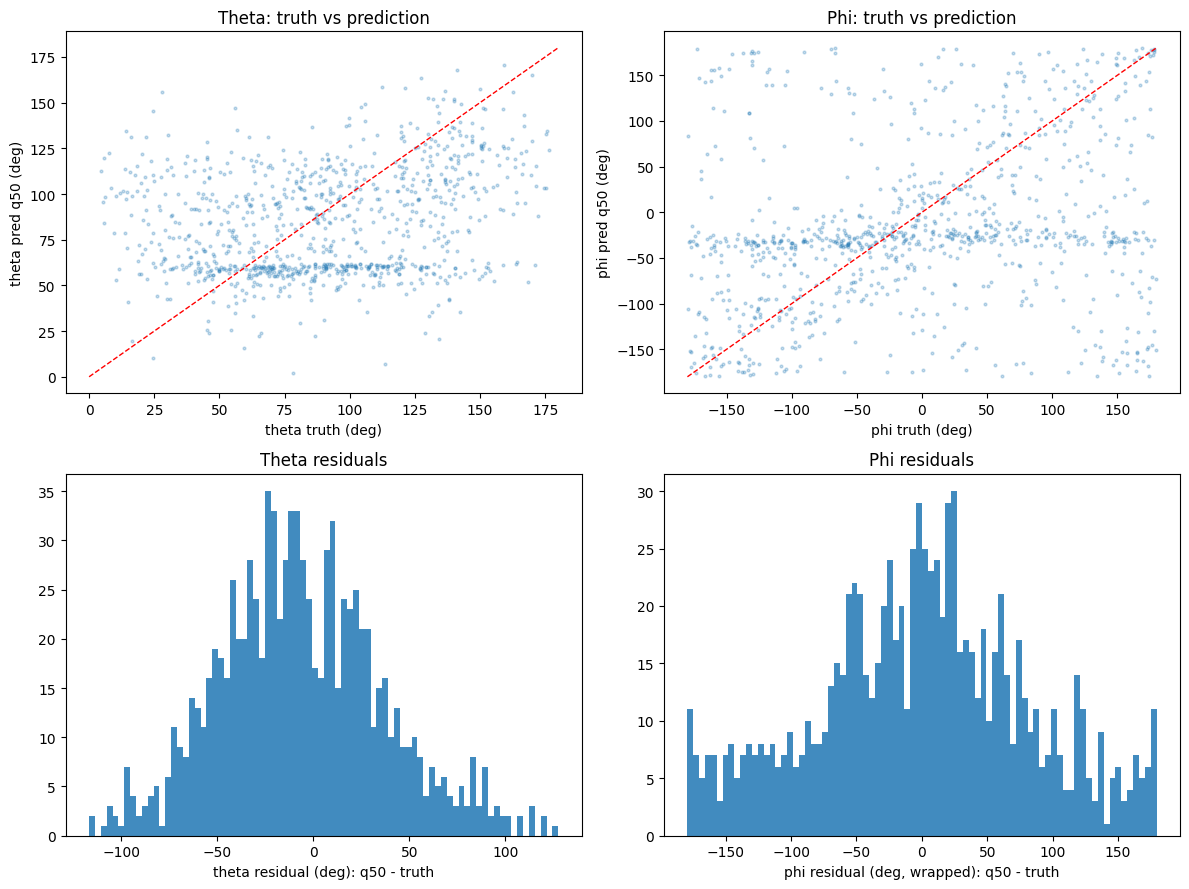

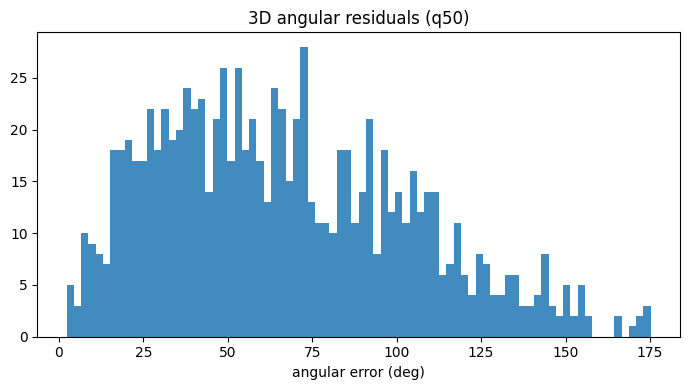

Angular error deg: {'mean': 66.82864379882812, 'p50': 62.45597839355469, 'p90': 117.81133270263672}


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# theta truth vs pred
ax = axes[0, 0]
ax.scatter(theta_t_deg, theta_50_deg, s=4, alpha=0.25)
ax.plot([0, 180], [0, 180], 'r--', linewidth=1)
ax.set_xlabel('theta truth (deg)')
ax.set_ylabel('theta pred q50 (deg)')
ax.set_title('Theta: truth vs prediction')

# phi truth vs pred (wrapped)
ax = axes[0, 1]
ax.scatter(phi_t_deg, phi_50_deg, s=4, alpha=0.25)
ax.plot([-180, 180], [-180, 180], 'r--', linewidth=1)
ax.set_xlabel('phi truth (deg)')
ax.set_ylabel('phi pred q50 (deg)')
ax.set_title('Phi: truth vs prediction')

# theta residuals
ax = axes[1, 0]
ax.hist(theta_res_deg, bins=80, alpha=0.85)
ax.set_xlabel('theta residual (deg): q50 - truth')
ax.set_title('Theta residuals')

# phi residuals (wrapped)
ax = axes[1, 1]
ax.hist(phi_res_deg, bins=80, alpha=0.85)
ax.set_xlabel('phi residual (deg, wrapped): q50 - truth')
ax.set_title('Phi residuals')

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(ang_deg, bins=80, alpha=0.85)
plt.xlabel('angular error (deg)')
plt.title('3D angular residuals (q50)')
plt.tight_layout()
plt.show()

print('Angular error deg:', {
    'mean': float(np.mean(ang_deg)),
    'p50': float(np.percentile(ang_deg, 50)),
    'p90': float(np.percentile(ang_deg, 90)),
})

